In [ ]:
import zipfile

In [ ]:
import os
import random
import zipfile
from sklearn.model_selection import train_test_split
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation , GlobalAveragePooling2D ,DepthwiseConv2D ,Input ,Add ,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import ReLU, LeakyReLU
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping , LearningRateScheduler
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
!pip install tensorflow-addons==0.17.1
import tensorflow_addons as tfa

Try 3

In [ ]:
zip_path = "/content/drive/MyDrive/train.zip"  # Path to the ZIP file
extracted_path = "/content/chest_ctscan_images"  # Path to extract the files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

In [ ]:
train_dir = os.path.join(extracted_path, "train")
valid_dir = "/content/chest_ctscan_images/valid"
test_dir = "/content/chest_ctscan_images/test"

In [ ]:
# Create a validation set from a portion of the training set
def create_validation_set(source_dir, validation_dir, validation_ratio=0.2):
    if not os.path.exists(validation_dir):
        os.makedirs(validation_dir)

    for class_name in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_name)
        class_valid_path = os.path.join(validation_dir, class_name)

        if not os.path.exists(class_valid_path):
            os.makedirs(class_valid_path)

        all_files = os.listdir(class_source_path)
        train_files, valid_files = train_test_split(all_files, test_size=validation_ratio, random_state=42)

        for file in valid_files:
            shutil.move(os.path.join(class_source_path, file), os.path.join(class_valid_path, file))

create_validation_set(train_dir, valid_dir, validation_ratio=0.2)  # Split 20% for validation


In [ ]:
# Example code to create a test set from a portion of the training set
def create_test_set(source_dir, test_dir, test_ratio=0.1):
    # Create test directory if it doesn't exist
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for class_name in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_name)
        class_test_path = os.path.join(test_dir, class_name)

        if not os.path.exists(class_test_path):
            os.makedirs(class_test_path)

        all_files = os.listdir(class_source_path)
        train_files, test_files = train_test_split(all_files, test_size=test_ratio, random_state=42)

        for file in test_files:
            shutil.move(os.path.join(class_source_path, file), os.path.join(class_test_path, file))

create_test_set(train_dir, test_dir, test_ratio=0.18)  # Split 10% for test


In [ ]:
train_datagen = ImageDataGenerator(
    # rescale=1.0/255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
)

In [ ]:
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=16,
    class_mode='categorical'
)

Found 654 images belonging to 4 classes.


In [ ]:
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(256,256),
    batch_size=16,
    class_mode='categorical'
)

Found 201 images belonging to 4 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=16,
    class_mode='categorical'
)

Found 145 images belonging to 4 classes.


In [ ]:
os.makedirs(test_dir, exist_ok=True)


In [ ]:
# Example to list files in the test directory
test_files = os.listdir(test_dir)
print("Number of files in test directory:", len(test_files))

Number of files in test directory: 4


In [ ]:
print("Test directory:", test_dir)


Test directory: /content/chest_ctscan_images/test


In [ ]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [ ]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=4, average="micro", name='f1_score')
]

In [ ]:
# Basic Convolution Block
def conv_block(inputs, filters, kernel_size, strides=1, activation='relu'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

In [ ]:
# Squeeze-and-Excitation (SE) Block
def squeeze_excite_block(inputs, ratio=16):
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape([1, 1, filters])(se)
    x = layers.Multiply()([inputs, se])
    return x

In [ ]:
# Spatial Attention (SA) Block
def spatial_attention_block(inputs):
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(inputs)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(inputs)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    sa = layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    x = layers.Multiply()([inputs, sa])
    return x


In [ ]:
# Building Blocks
def block(inputs, filters, num_blocks):
    x = inputs
    for _ in range(num_blocks):
        x = conv_block(x, filters, (3, 3))
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
    return x

def se_sa_block(inputs, filters):
    x = conv_block(inputs, filters, (3, 3))
    se = squeeze_excite_block(x)
    sa = spatial_attention_block(x)
    x = layers.Add()([se, sa])
    return x


In [ ]:
# ISANET Model
def ISANET(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolutional Layers
    x = conv_block(inputs, 64, (3, 3))
    x = conv_block(x, 64, (3, 3))
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 1
    x = block(x, 192, 1)

    # Block 2
    x = block(x, 288, 2)

    # Block 3
    x = block(x, 768, 3)

    # Squeeze and Excitation Block
    se = squeeze_excite_block(x)

    # Spatial Attention Block
    sa = spatial_attention_block(x)

    # Combining SE and SA blocks
    x = layers.Add()([se, sa])

    # Final Layers
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(4, activation='softmax')(x)  # 4 classes, softmax activation for multi-class classification

    model = models.Model(inputs, outputs)
    return model

# Example usage
input_shape = (256, 256, 3)
model = ISANET(input_shape)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_16 (Ba  (None, 256, 256, 64)         256       ['conv2d_18[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_16

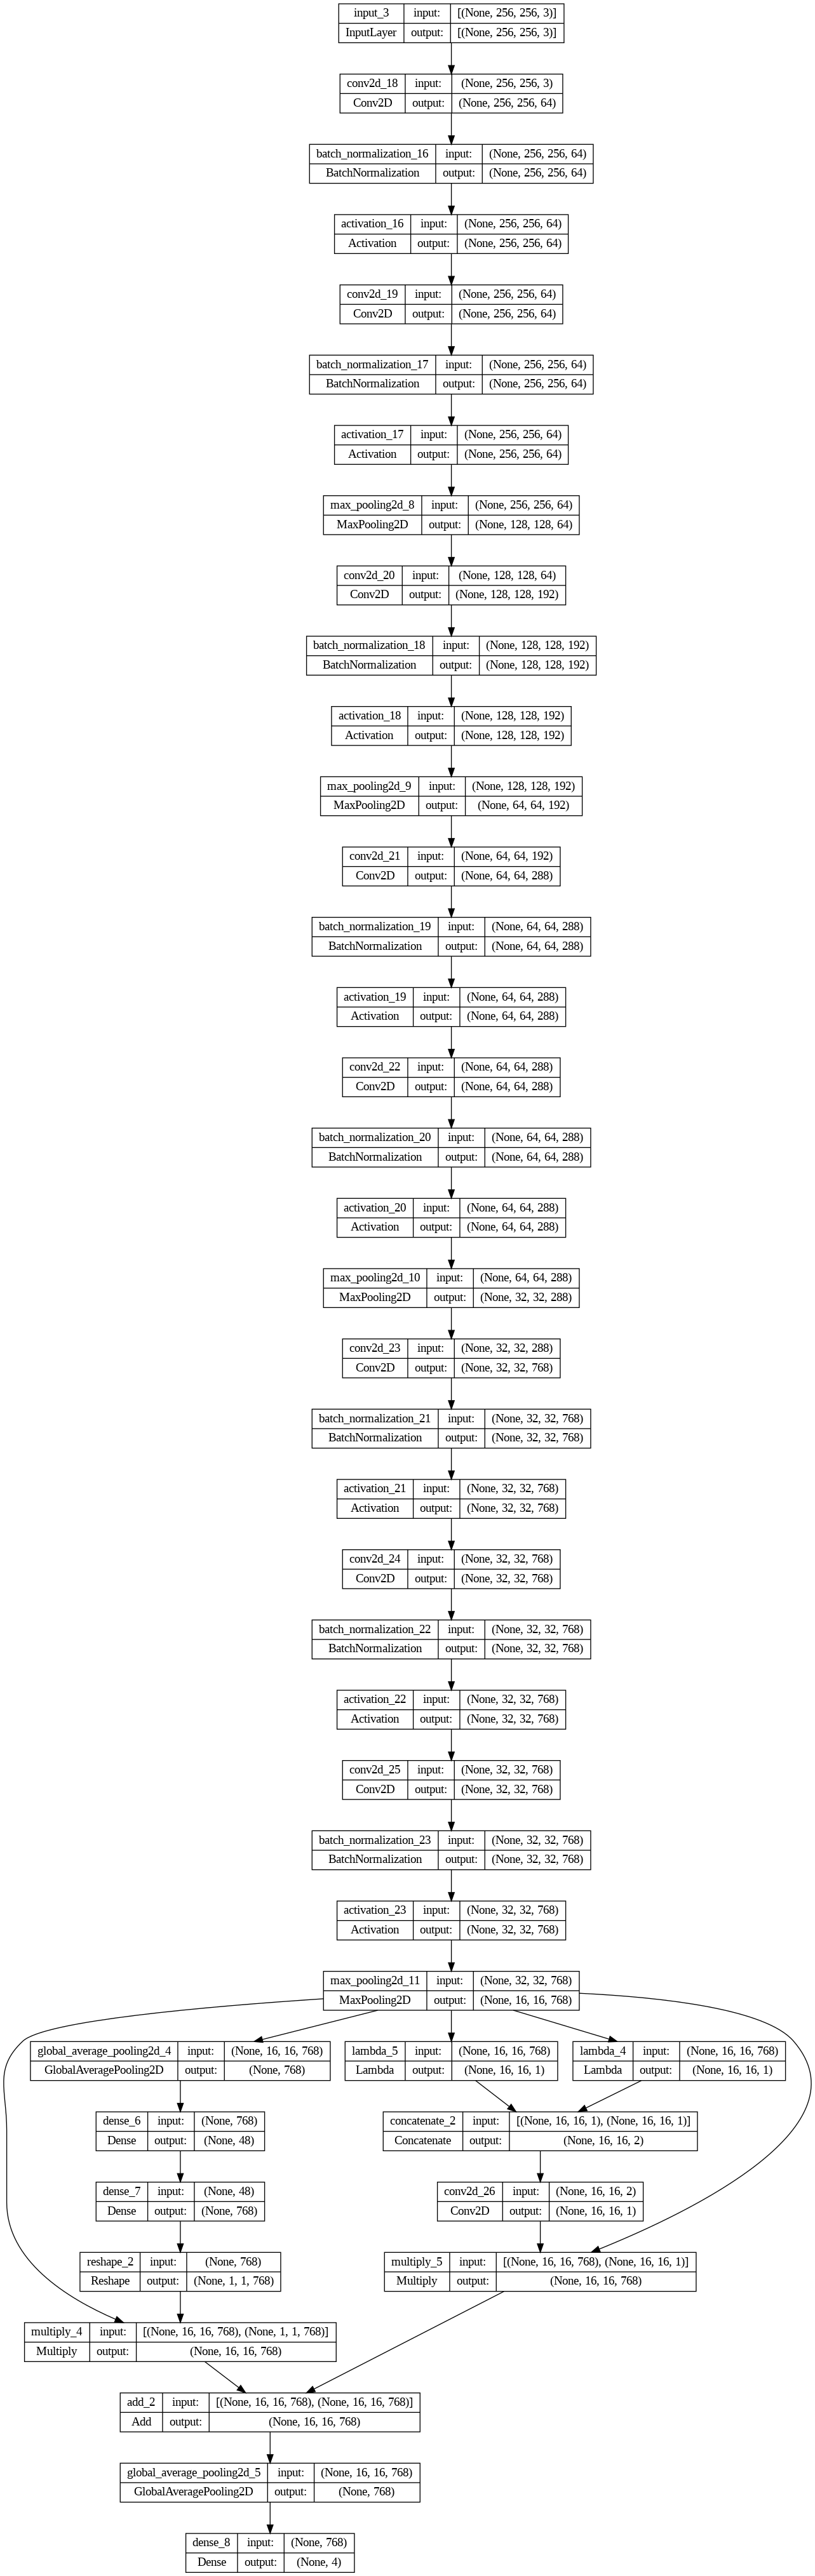

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0005),
    metrics=METRICS
)

In [ ]:
def lr_schedule(epoch,learning_rate):
  if epoch <7:
    return learning_rate
  else:
    return 0.95*learning_rate

lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
# print("Length of train_dataset:", len(train_dataset))
# print("Length of valid_dataset:", len(valid_dataset))

In [ ]:
callbacks = [
    ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)#,
    # EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)
]

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=callbacks,
        verbose=1
    #  , class_weight=class_weights
)

Epoch 1/35
41/41 [==============================] - ETA: 0s - loss: 1.3776 - accuracy: 0.4572 - precision: 0.5323 - recall: 0.3272 - auc: 0.7527 - f1_score: 0.4572
Epoch 1: val_accuracy improved from -inf to 0.21393, saving model to best_model.keras
41/41 [==============================] - 34s 484ms/step - loss: 1.3776 - accuracy: 0.4572 - precision: 0.5323 - recall: 0.3272 - auc: 0.7527 - f1_score: 0.4572 - val_loss: 54.5151 - val_accuracy: 0.2139 - val_precision: 0.2139 - val_recall: 0.2139 - val_auc: 0.4760 - val_f1_score: 0.2139
Epoch 2/35
41/41 [==============================] - ETA: 0s - loss: 0.9871 - accuracy: 0.5260 - precision: 0.6433 - recall: 0.3226 - auc: 0.8124 - f1_score: 0.5260
Epoch 2: val_accuracy improved from 0.21393 to 0.21891, saving model to best_model.keras
41/41 [==============================] - 17s 399ms/step - loss: 0.9871 - accuracy: 0.5260 - precision: 0.6433 - recall: 0.3226 - auc: 0.8124 - f1_score: 0.5260 - val_loss: 11.6524 - val_accuracy: 0.2189 - val

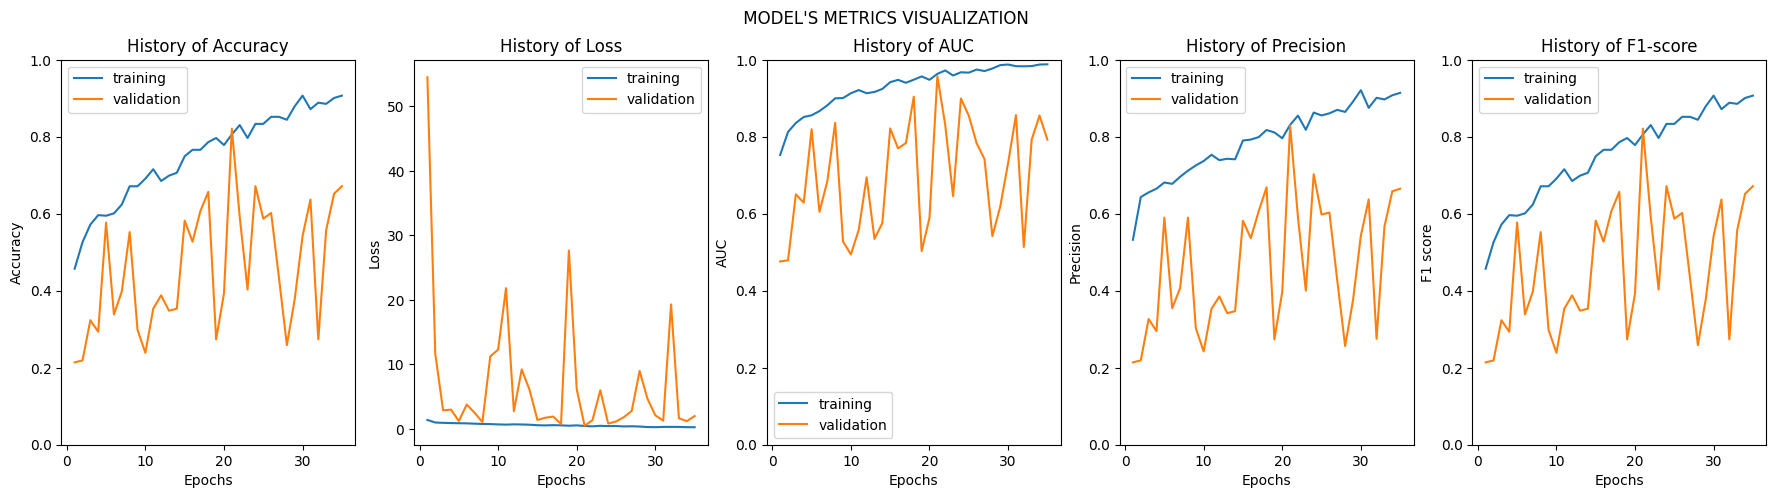

In [ ]:
def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, f1, val_f1):

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(22, 5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    # Rescale the y-axis for accuracy, auc, precision, and f1
    rescale_factor = 0  # Adjust this factor to control the rescaling

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1.0])
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.set_ylim([rescale_factor, 1.0])
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.set_ylim([rescale_factor, 1.0])
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.set_ylim([rescale_factor, 1.0])
    ax5.legend(['training', 'validation'])

    plt.show()

# Example usage:
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss']
               ,
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['f1_score'], history.history['val_f1_score'])


In [ ]:
model.evaluate(test_generator)

10/10 [==============================] - 3s 260ms/step - loss: 1.9134 - accuracy: 0.6759 - precision: 0.6667 - recall: 0.6207 - auc: 0.7935 - f1_score: 0.6759


[1.9134334325790405,
 0.6758620738983154,
 0.6666666865348816,
 0.6206896305084229,
 0.7934759259223938,
 0.6758620738983154]

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
# Load the test dataset
X_test, y_test = [], []
for i in range(len(test_generator)):
    batch_X, batch_y = test_generator[i]
    X_test.append(batch_X)
    y_test.append(batch_y)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the one-hot encoded true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Create a classification report
report = classification_report(y_true_classes, y_pred_classes)

print(report)

5/5 [==============================] - 18s 2s/step
              precision    recall  f1-score   support

           0       0.77      0.76      0.76        49
           1       0.00      0.00      0.00        27
           2       0.94      0.94      0.94        31
           3       0.48      0.84      0.62        38

    accuracy                           0.68       145
   macro avg       0.55      0.63      0.58       145
weighted avg       0.59      0.68      0.62       145



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


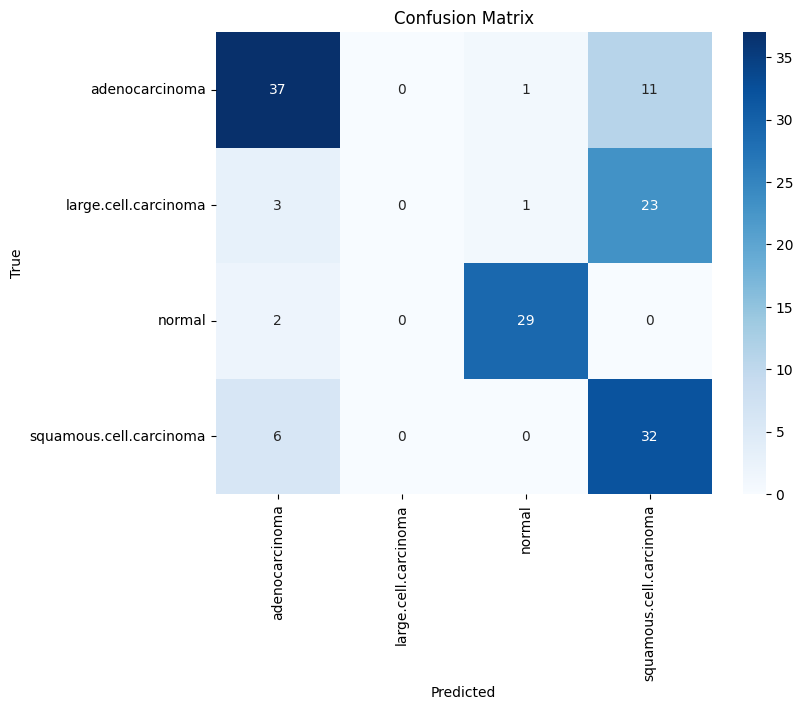

In [ ]:
class_names = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
